### LIME to explain image classification 

The task of this notebook is to explain the black-box vision-transformer prediction for classification of brain cancer. 


### Lime (Local Interpretable Model-agnostic Explanations)
Lime can be used to explain any black-box model. In short it works by permuting a single input feature (the feature which you want to explain) and then training a regression model on the permuted features and the black-box predictions. 


When we apply lime to explain image classification we first use image segmentation, in our case superpixels. Each of these superpixels are treated as a meaningful explanation of the data. 

Then lime crates permuted images by turning super pixels on and off. 

Then lime performs black-box predictions based on these permuted images. These predictions then gives insight in how each superpixel effect the output. 

Finally lime fits a regression model which model the relationship between superpixel and output. This gives us an indication of super pixel importance. 

### References 

https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image

https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import lightning as L
from torchvision.models import vit_b_16 # pretrained model'
from torchsummary import summary
import torchmetrics

import brain_tumor_dataset as btd

# Pre trained model

In [79]:
# Define the transformation for the images
transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
	transforms.Resize((224, 224)),                 # resize to 224x224
	transforms.ToTensor(),
])
random_seed = 42
torch.manual_seed(random_seed) #for reproducabillity 

# Load your datasets with the defined transformations
train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)
test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

val_size = len(test_dataset) // 2
test_size = len(test_dataset) - val_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset), len(val_dataset)

(5712, 656, 655)

In [80]:
import cv2
# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self, 
			  learning_rate=1e-4, 
			  pretrained_weights = "IMAGENET1K_V1",
			  weights_path=None):
		super().__init__()
		# Initialize the model with the pre-trained ViT
		self.model = vit_b_16(weights=pretrained_weights)
		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Load the weights if provided
		if weights_path:
			pass
			# self.load_from_checkpoint(weights_path, map_location=self.device)


		# Define loss function and learning rate
		self.criterion = torch.nn.CrossEntropyLoss()
		self.learning_rate = learning_rate

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

		self.attention_maps = {}  # To store attention maps

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss
	
	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		return loss

	def test_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('test_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('test_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		self.log_attention_maps(inputs, labels)  # Save attention maps

		return loss
	
	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
	
	def register_attention_hooks(self):
		"""Register hooks to capture attention maps."""
		self.attention_maps.clear()  # Reset attention maps

		def hook_fn(module, input, output, module_name):
			module_name = module_name.split(".")[2]  # Get the layer name

			q, k, _ = input
			self.attention_maps[module_name] = torch.nn.functional.softmax(q @ k.transpose(-2, -1))  # Save attention map

		# Register hooks on all MultiheadAttention layers
		for i, module in self.model.named_modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(lambda module, input, output, module_name=i: hook_fn(module, input, output, module_name))
	
	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		self.register_attention_hooks()

	def log_attention_maps(self, inputs, labels):
			"""Log attention maps overlaid on the original image using Lightning's logger."""
			batch_size = inputs.size(0)
			for i in range(batch_size):
				average_attention_map = None
				num_layers = len(self.attention_maps)
				for _, attention in self.attention_maps.items():
					# Get the attention map for the first image in the batch
					attention_map = attention[i]  # Shape: [num_tokens, embedding_size]
					
					# Compute cosine similarity between class token and patches
					class_token_embedding = attention_map[0, :]  # Shape: (embedding_size)
					num_patches_side = int((attention_map.size(0) - 1) ** 0.5)
					attention_map = class_token_embedding[1:].view(num_patches_side, num_patches_side, -1).clone()
					
					# Accumulate attention maps
					if average_attention_map is None:
						average_attention_map = attention_map
					else:
						average_attention_map += attention_map

				average_attention_map = average_attention_map / num_layers
				average_attention_map = average_attention_map.cpu().detach().numpy()
				average_attention_map = cv2.resize(average_attention_map, (inputs.size(2), inputs.size(3)))
				heatmap = cv2.applyColorMap(np.uint8(255 * average_attention_map), cv2.COLORMAP_JET)

				# Overlay the heatmap on the original image
				image = inputs[i].cpu().numpy().transpose(1, 2, 0)
				image = (image*255).astype(np.uint8)
				overlayed_image = cv2.addWeighted(image, 0.8, heatmap, 0.4, 0)

				# add class label
				label = labels[i].item()
				label = train_dataset.idx_to_class[label]
				cv2.putText(overlayed_image, f"Class: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

				# convert to chw
				overlayed_image = overlayed_image.transpose(2, 0, 1)

				# log to tensorboard
				self.logger.experiment.add_image(f'attention_map/image_{i}', overlayed_image, self.current_epoch)

				# # Plot the attention map
				# average_attention_map /= num_layers
				# plt.figure(figsize=(8, 8))
				# plt.imshow(average_attention_map.cpu().detach().numpy(), cmap='coolwarm', interpolation='nearest')
				# plt.colorbar()
				# plt.title(f'Average Attention Map - Image {i}')
				# plt.show()

# Define callbacks
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
	monitor="val_loss",                     # Monitor validation loss
	mode = "min",                           # mode for monitored metric
	dirpath="checkpoints/",                   # Directory to save checkpoints
	filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",  # Naming pattern
	save_top_k=-1,                          # Save all checkpoints
	every_n_epochs=1,                       # Save at every epoch
)

early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
	monitor="val_loss",                     # Metric to monitor
	patience=5,                             # Stop training if no improvement for 5 epochs
	mode="min",                             # Stop when `val_loss` stops decreasing
	verbose=True,
)

logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")


# Define the PyTorch Lightning Trainer
trainer = L.Trainer(max_epochs=10, 
					accelerator="auto", 
					logger=logger,
					callbacks=[checkpoint_callback, early_stopping_callback])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [81]:
# Create the model instance
weights_path = "logs/vit_pretrained/version_0/epoch-epoch=04-val_loss-val_loss=0.01.ckpt"
model = BrainTumorClassifier()
model = BrainTumorClassifier.load_from_checkpoint(weights_path, map_location=model.device)

In [82]:
# Train the model
#trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [83]:
# Test the model
#trainer.test(model, dataloaders=test_loader)

In [84]:
from lime import lime_image

In [85]:
explainer = lime_image.LimeImageExplainer(verbose=True, random_state= 1, kernel_width=0.5)

In [88]:
image = val_dataset[1]

In [89]:
image

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0275, 0.0196, 0.0000],
          [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0275, 0.0196, 0.0000],
          [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078,  ...,

In [90]:
image = image[0]

In [91]:
image_np = image.permute(1, 2, 0).cpu().numpy()  # [3, 224, 224] -> [224, 224, 3]

# Ensure the data type is float32
image_np = image_np.astype(np.float32)

In [92]:
def predict_func(inputs):
    """
    Predict function compatible with LIME for batch predictions.

    Args:
        inputs: NumPy array of shape (batch_size, height, width, channels)

    Returns:
        NumPy array of probabilities of shape (batch_size, num_classes)
    """
    # Convert NumPy array to PyTorch tensor and reshape to [batch_size, channels, height, width]
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
    
    # Move tensor to the same device as the model
    inputs_tensor = inputs_tensor.to(model.device)
    
    with torch.no_grad():
        # Forward pass for predictions
        outputs = model(inputs_tensor)  # Shape: [batch_size, num_classes]

        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert to NumPy
    
    return probabilities


In [93]:
explanation = explainer.explain_instance(image_np, predict_func, top_labels=1, num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Intercept 0.9594263300286784
Prediction_local [1.02392173]
Right: 0.9997768


### Comments 
Model is very sure of the prediction, however intercept is very high, which will in turn make the weights of the local model very small thus making it harder to distinguish between superpixel importace. 

This can be fixed by playing around with the kernel width. 


In [104]:
explanation.top_labels

[3]

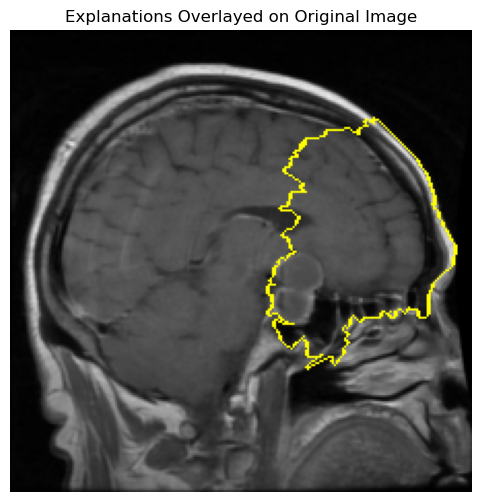

In [103]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Label to explain
    positive_only=True,               # Show only positive contributions
    num_features=1,                  # Number of superpixels to highlight
    hide_rest=False                   # Show the rest of the image
)


# Create the overlay with boundaries on the original image
overlay_image = mark_boundaries(temp, mask)

# Plot the overlay on top of the original image
plt.figure(figsize=(6, 6))
plt.imshow(overlay_image)
plt.axis("off")
plt.title("Explanations Overlayed on Original Image")
plt.show()


In [76]:
#måke overvej der er noget med normalisering og preprosseing der lige skal tjekkes op på. twak mængden af superpixels + kernel with. 

In [77]:
#svar fra jose 

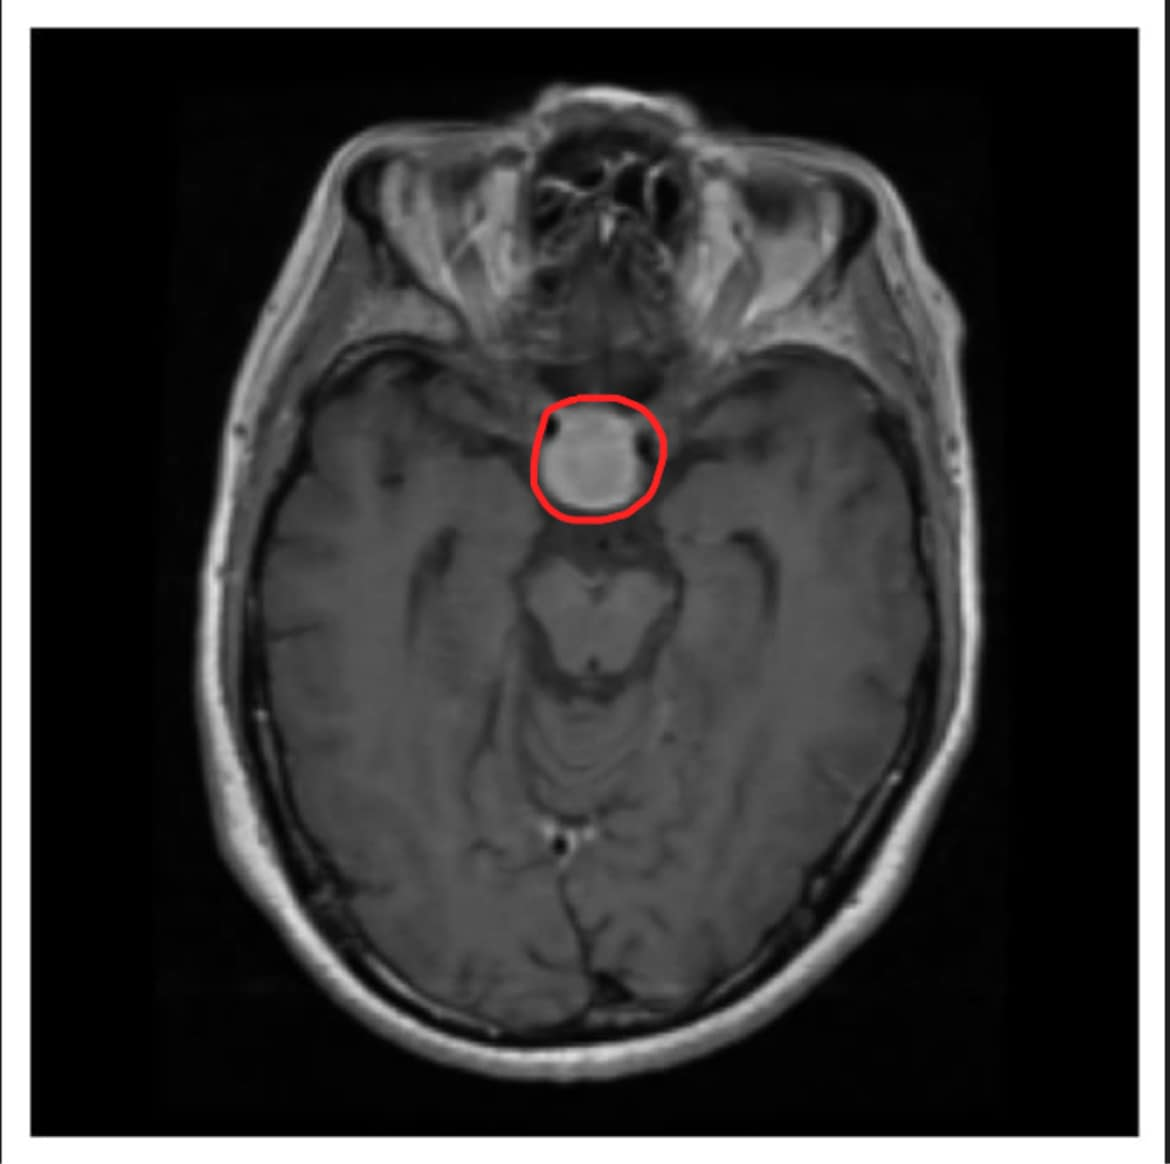